# Project Overview

# Actually, I used an SVD model, not a hybrid model! Need to update the above!

# Datasets

This project utilizes the MovieLens dataset, a widely used dataset in the field of recommender systems, containing movie ratings and metadata.  The data was obtained at https://www.kaggle.com/datasets/parasharmanas/movie-recommendation-system/data.  There are two data files. The first contains the unique movie Id, movie title and a list of genres the movie falls into.  The second consists of user ratings with the user ID, movie ID, rating and timestap of when the review was made.

# PRIOR NOTES - MOVE

The plot above shows the trend of average movie ratings on a monthly basis. Observing the fluctuations in average ratings over time can provide insights into various factors, such as:
- User Rating Behavior: Changes in average ratings might indicate shifts in user rating behavior or the platform's user base.
- Content Quality: Variations might also reflect the release of particularly popular (or unpopular) movies during certain periods.


**Seasonal Trends in Movie Ratings**
- Average Ratings by Month: The bar chart provides a clear visualization of how average ratings vary by month. Peaks and troughs can suggest periods of high and low engagement or satisfaction, which can be tied to holiday seasons or specific movie releases.
- Genre Popularity by Month: The heatmap shows how different genres perform across months, revealing any seasonal preferences for genres. For example, holiday-themed or blockbuster genres might show distinct patterns during certain months like December or summer months.


Typical Accuracy Levels:

- General Accuracy: It's challenging to state a specific "average accuracy" because it depends highly on the context and the specific system configuration. However, good movie recommendation systems generally achieve:
    - RMSE: Values around 0.8 to 1.2 for rating predictions, with lower values indicating better accuracy.
    - Precision/Recall: Precision and recall can vary, but good systems might achieve over 20-30% precision in top-N recommendations in practical settings.
    - High-Performance Systems: In competitions like the Netflix Prize, the winning entries achieved RMSEs around 0.85, considered very high accuracy in a real-world system.

# REVISED CODE

In [48]:
# conda install joblib

In [49]:
## Optimized Code

## Import Libraries

In [51]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict
from joblib import Parallel, delayed
import logging
from tqdm import tqdm

# Use ggplto style for graphs
plt.style.use('ggplot')
sns.set_palette('colorblind')

# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Setup logging
logging.basicConfig(level=logging.INFO)


## Load and Merge Data

In [53]:
# Load and merge movies and ratings data with essential columns and a subset of ratings
def load_and_merge_data(movies_file, ratings_file):
    try:
        movies_df = pd.read_csv(movies_file, usecols=['movieId', 'title', 'genres'])
        ratings_df = pd.read_csv(ratings_file, usecols=['userId', 'movieId', 'rating'])

        # Remove duplicates
        movies_df.drop_duplicates(subset=['movieId'], inplace=True)
        ratings_df.drop_duplicates(subset=['userId', 'movieId'], inplace=True)

        # Handle missing values
        movies_df.fillna({'genres': '(no genres listed)'}, inplace=True)
        ratings_df.dropna(subset=['userId', 'movieId', 'rating'], inplace=True)

        merged_df = pd.merge(ratings_df, movies_df, on='movieId')
        logging.info("Data successfully merged and cleaned.")
        return merged_df
    except FileNotFoundError as e:
        logging.error(f"Error: {e}. File not found. Check the file paths.")
        return None
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return None


In [ ]:
CODE TO RUN

# Initial EDA

In [10]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [12]:
movies_df.describe(include='all')

,movieId,title,genres
count,9742.000000,9742,9742
unique,NaN,9737,951
top,NaN,Emma (1996),Drama
freq,NaN,2,1053
mean,42200.353623,NaN,NaN
std,52160.494854,NaN,NaN
min,1.000000,NaN,NaN
25%,3248.250000,NaN,NaN
50%,7300.000000,NaN,NaN
75%,76232.000000,NaN,NaN


Movies Dataframe Summary:
- There are 9,742 unique movies.
- The genres column has 951 unique genre combinations, with 'Drama' being the most frequent.  The number of genres does not appear resaonable, so will conduct further analysis on.
- The movieId ranges from 1 to 193,609, indicating a broad and possibly sparse numbering system, as there are only 9,737 unique movie titles.

In [14]:
movies_df.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

There are no missing values in the movies dataset.

In [16]:
movies_df.duplicated().sum()

0

There are no duplicate rows in the movies dataset.

In [18]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [19]:
ratings_df.describe(include='all')

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Ratings Dataframe Summary:
- Contains 100,836 ratings.
- userId ranges from 1 to 610, indicating 610 unique users.
- Ratings range from 0.5 to 5.0, in increments of 0.5.
- The average rating is approximately 3.50.
- timestamp is an integer representing the time the user rating was made.

I will now merge the two datasets which will allow us to see which user rated which movie, along with the movie's title and genres.

In [22]:
# Merge the two df's on movieId
df = movies_df.merge(ratings_df, on='movieId')

df.shape

(100836, 6)

In [23]:
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [24]:
df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [26]:
df.describe(include='all')

,movieId,title,genres,userId,rating,timestamp
count,100836.000000,100836,100836,100836.000000,100836.000000,1.008360e+05
unique,NaN,9719,951,NaN,NaN,NaN
top,NaN,Forrest Gump (1994),Comedy,NaN,NaN,NaN
freq,NaN,329,7196,NaN,NaN,NaN
mean,19435.295718,NaN,NaN,326.127564,3.501557,1.205946e+09
std,35530.987199,NaN,NaN,182.618491,1.042529,2.162610e+08
min,1.000000,NaN,NaN,1.000000,0.500000,8.281246e+08
25%,1199.000000,NaN,NaN,177.000000,3.000000,1.019124e+09
50%,2991.000000,NaN,NaN,325.000000,3.500000,1.186087e+09
75%,8122.000000,NaN,NaN,477.000000,4.000000,1.435994e+09


Combined Dataset Statistics:
- The dataset contains 100,836 ratings for 9,719 unique movies.
- The genres column has 951 unique genre combinations, with 'Comedy' being the most frequent.
- Ratings range from 0.5 to 5.0, with an average of approximately 3.50.

In [28]:
df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

There are no missing values in the combined dataset

In [30]:
df.duplicated().sum()

0

## Univariate Analysis

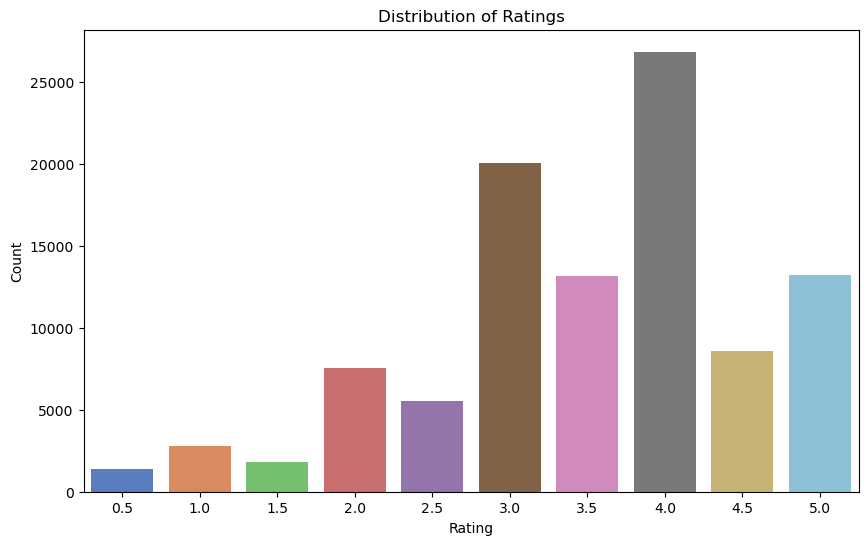

In [32]:
# Plot ratings distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', hue='rating', data=df, legend=False, palette='muted'
             )
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


The distribution of ratings shows that:
- Ratings are discrete, in increments of 0.5.
- The most common ratings are around 3.0 to 4.0, indicating a tendency towards higher ratings.
- The extreme ratings (0.5 and 5.0) are less common, suggesting that users are generally moderate in their assessments.

C:\Users\trobb\AppData\Local\Temp\ipykernel_6648\3179706429.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(genre_counts, kind='bar', palette='muted', height=5, aspect=2)


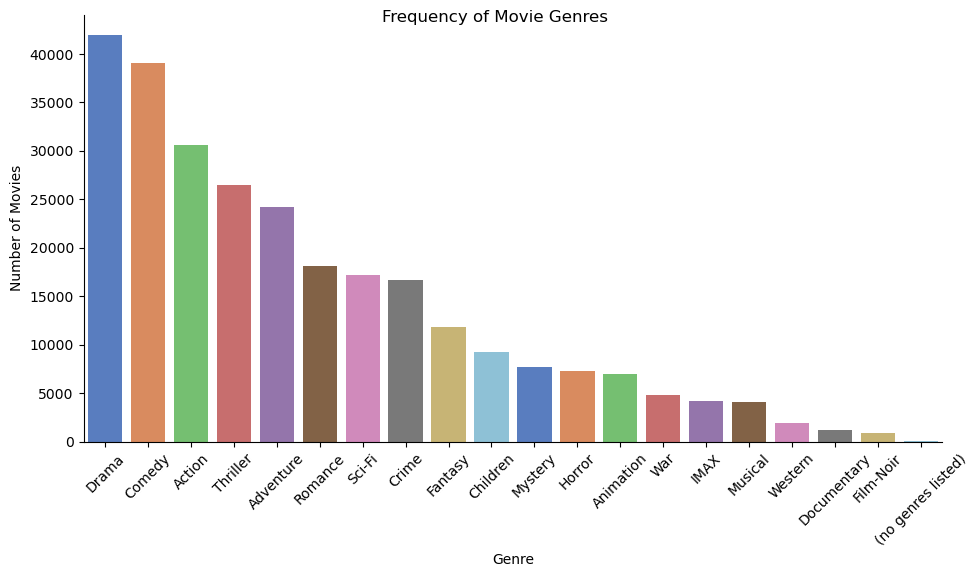

In [34]:
# split genres by | and add as a list
df['genres'] = df['genres'].apply(lambda x:x.split('|'))
                                  
df.head()

# Break out genres included in list and determine count of each
import matplotlib.pyplot as plt

# Explode the genres column to have separate row for each genre
exploded_genres = df.explode('genres')

# Count the occurrences of each genre
genre_counts = exploded_genres['genres'].value_counts()
genre_counts

# Plot the genre frequencies

g = sns.catplot(genre_counts, kind='bar', palette='muted', height=5, aspect=2)
g.fig.suptitle('Frequency of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

In [ ]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

# Function to train and evaluate SVD model
def train_and_evaluate_svd(df):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

    # Using fixed parameters
    svd_params = {
        'n_factors': 150,
        'n_epochs': 30,
        'lr_all': 0.005,
        'reg_all': 0.1,
        'biased': True,
        'random_state': 42
    }

    model = SVD(**svd_params)
    model.fit(trainset)

    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    print(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")
    print(f"Best Parameters: {svd_params}")

    return model, testset

# Train the SVD model and obtain predictions (uncomment below)
# model, testset = train_and_evaluate_svd(df)


## Bivariate Analysis

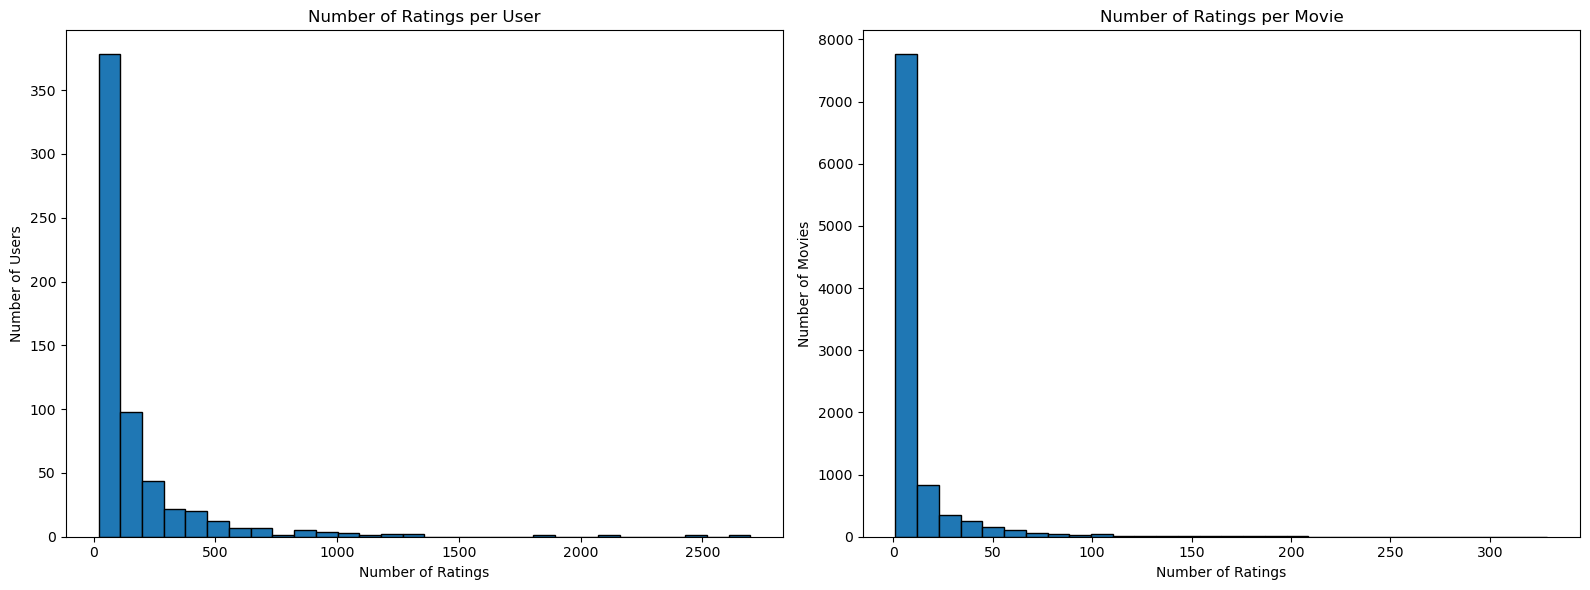

In [36]:
import matplotlib.pyplot as plt

# Assuming 'ratings_df' is your DataFrame
user_rating_counts = ratings_df['userId'].value_counts()
movie_rating_counts = ratings_df['movieId'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for number of ratings per user
axes[0].hist(user_rating_counts, bins=30, edgecolor='black')
axes[0].set_title('Number of Ratings per User')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Number of Users')

# Plot for number of ratings per movie
axes[1].hist(movie_rating_counts, bins=30, edgecolor='black')
axes[1].set_title('Number of Ratings per Movie')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Movies')

plt.tight_layout()
plt.show()



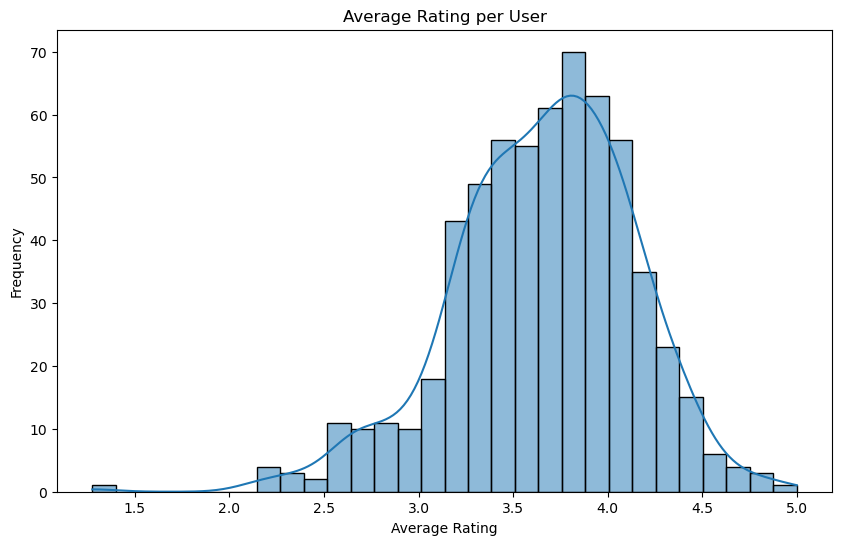

In [37]:
# Average Rating per User

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average rating per user
user_avg_ratings = ratings_df.groupby('userId')['rating'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(user_avg_ratings, bins=30, kde=True)
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()


# Distribution of Ratings across genres


## Need to add

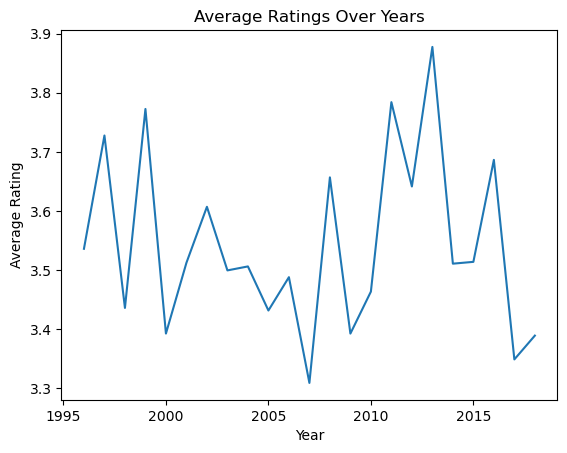

In [39]:
# Ratings over Time
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['year'] = ratings_df['datetime'].dt.year
ratings_df.groupby('year')['rating'].mean().plot(kind='line')
plt.title('Average Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()


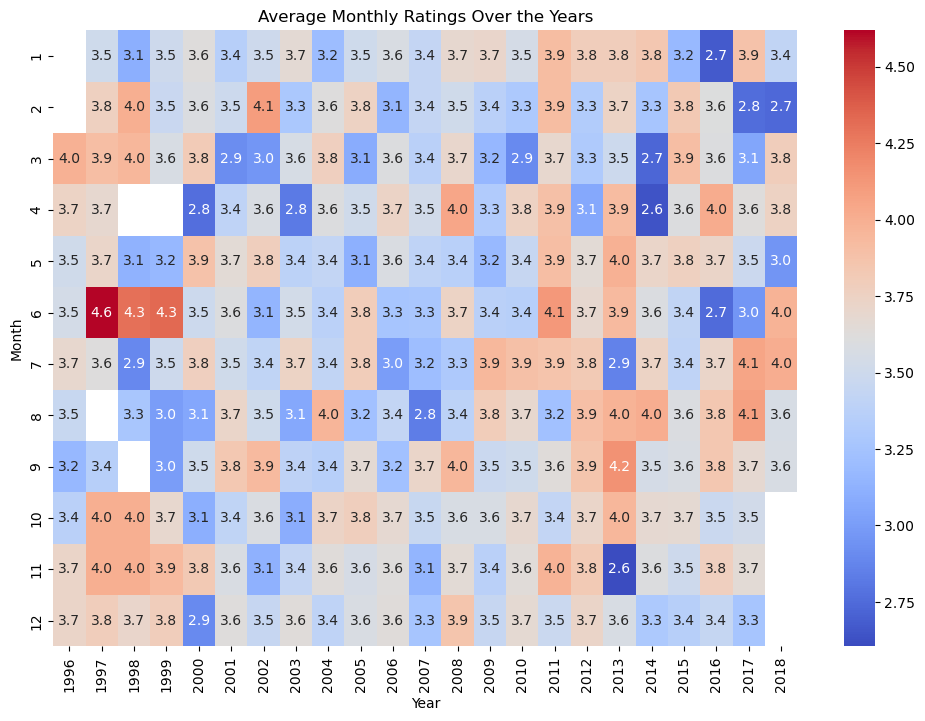

In [40]:
# Heatmap of Ratings Over Time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'timestamp' is a UNIX timestamp in 'ratings_df'
ratings_df['date'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['year'] = ratings_df['date'].dt.year
ratings_df['month'] = ratings_df['date'].dt.month

# Pivot table to prepare data for heatmap
rating_pivot = ratings_df.pivot_table(values='rating', index='month', columns='year', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(rating_pivot, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Average Monthly Ratings Over the Years')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()



In [41]:
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,964982703
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,847434962
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,1106635946
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,1510577970
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,1305696483


## Preprocess Data

In [56]:
# Preprocess data by adding one-hot encoding for genres
def preprocess_data(df):
    if 'genres' in df.columns:
        df['genres'] = df['genres'].replace('', '(no genres listed)')
        genres_dummies = df['genres'].str.get_dummies(sep='|')
        df = pd.concat([df, genres_dummies], axis=1)
        logging.info("Genre-based features added.")
    else:
        logging.info("Genres column not available for processing.")
    return df

# Add user-genre interaction features to the dataset
def add_user_genre_features(df):
    if 'userId' in df.columns:
        # Select only genre columns for aggregation
        genre_columns = [col for col in df.columns if col not in ('user_mean_', 'title', 'movieId', 'userId', 'rating') and df[col].dtype in [np.float64, np.int64]]

        # Compute mean genre features per user
        user_genre_means = df.groupby(['userId'])[genre_columns].mean()
        user_genre_means.columns = [f'user_mean_{col}' for col in user_genre_means.columns]

        # Merge the new features back into the main DataFrame
        df = pd.merge(df, user_genre_means, on='userId', how='left')
        logging.info("User-genre interaction features added.")
    else:
        logging.info("UserId column not available for interaction features.")
    return df

## Additional EDA

In [58]:
from joblib import Parallel, delayed
from sklearn.neighbors import NearestNeighbors
import logging

# Helper function for hybrid recommendations per user
def hybrid_user_recommendation_worker(user_id, df, svd_model, movie_indices, distances, indices, weight_svd, weight_content, n):
    user_recommendations = []

    try:
        for idx in movie_indices:
            sim_scores = list(enumerate(distances[idx]))
            sorted_indices = np.argsort([x[1] for x in sim_scores])[::-1][1:11]

            movie_indices_list = [indices[idx][i] for i in sorted_indices if indices[idx][i] in df.index]

            sim_movies = df['movieId'].iloc[movie_indices_list]
            svd_recs = [svd_model.predict(user_id, iid) for iid in sim_movies]

            recommendations = [
                (
                    iid,
                    weight_svd * est.est + weight_content * distances[idx][movie_indices_list.index(iid)]
                )
                for iid, est in zip(sim_movies, svd_recs)
                if iid in movie_indices_list
            ]

            recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)

            user_recommendations.extend(recommendations[:n])

        user_recommendations = sorted(user_recommendations, key=lambda x: x[1], reverse=True)[:n]

        return [(user_id, rec[0], rec[1]) for rec in user_recommendations]

    except ValueError as e:
        logging.error(f"Error in hybrid_user_recommendation_worker: {e}")
        return []

# Function to calculate sparse cosine similarity
def calculate_sparse_cosine_similarity(tfidf_matrix, n_neighbors=10):
    logging.info("Calculating sparse cosine similarity...")
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute').fit(tfidf_matrix)
    distances, indices = nbrs.kneighbors(tfidf_matrix)
    logging.info("Sparse cosine similarity calculated.")
    return distances, indices

# Hybrid recommendation function combining SVD and content-based filtering
def hybrid_recommendation_to_screen(df, svd_model, test_users, weight_svd=0.7, weight_content=0.3, n=5, batch_size=2000):
    movie_indices = pd.Series(df.index, index=df['title']).drop_duplicates()

    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')  # Increase vocabulary size to 1000
    tfidf_matrix = tfidf.fit_transform(df['genres'].fillna(''))
    distances, indices = calculate_sparse_cosine_similarity(tfidf_matrix, n_neighbors=10)

    all_recommendations = []

    logging.info(f"Processing users in batches of {batch_size}...")

    # Process users in batches
    for i in range(0, len(test_users), batch_size):
        batch_users = list(test_users)[i:i + batch_size]

        # Set n_jobs to -1 to use all processors
        batch_recommendations = Parallel(n_jobs=-1)(
            delayed(hybrid_user_recommendation_worker)(
                user_id, df, svd_model, movie_indices, distances, indices, weight_svd, weight_content, n
            )
            for user_id in batch_users
        )
        all_recommendations.extend([item for sublist in batch_recommendations for item in sublist])

    # Print recommendations to screen
    for rec in all_recommendations:
        print(f"User: {rec[0]}, Movie: {rec[1]}, Score: {rec[2]:.4f}")


## Train and Evaluate SVD Model

In [60]:
'''

# Train and evaluate the SVD model using fixed parameters
def train_and_evaluate_svd(df):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    trainset, testset = train_test_split(data, test_size=0.25, random_state=RANDOM_SEED)

    svd_params = {
        'n_factors': [150, 200, 250],  # Increase factors for better training
        'n_epochs': [30, 40, 50],   # Increase epochs
        'lr_all': 0.005,
        'reg_all': 0.1,
        'biased': True,
        'random_state': RANDOM_SEED  # Add random seed for reproducibility
    }

    model = SVD(**svd_params)
    model.fit(trainset)

    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    print(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")
    print(f"Best Parameters: {svd_params}")

    return model, testset
    
'''

'\n\n# Train and evaluate the SVD model using fixed parameters\ndef train_and_evaluate_svd(df):\n    reader = Reader(rating_scale=(0.5, 5.0))\n    data = Dataset.load_from_df(df[[\'userId\', \'movieId\', \'rating\']], reader)\n\n    trainset, testset = train_test_split(data, test_size=0.25, random_state=RANDOM_SEED)\n\n    svd_params = {\n        \'n_factors\': [150, 200, 250],  # Increase factors for better training\n        \'n_epochs\': [30, 40, 50],   # Increase epochs\n        \'lr_all\': 0.005,\n        \'reg_all\': 0.1,\n        \'biased\': True,\n        \'random_state\': RANDOM_SEED  # Add random seed for reproducibility\n    }\n\n    model = SVD(**svd_params)\n    model.fit(trainset)\n\n    predictions = model.test(testset)\n    rmse = accuracy.rmse(predictions)\n    mae = accuracy.mae(predictions)\n\n    print(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")\n    print(f"Best Parameters: {svd_params}")\n\n    return model, testset\n    \n'

In [61]:
'''

best_svd_model, svd_testset = train_and_evaluate_svd(augmented_ratings_df)

'''

'\n\nbest_svd_model, svd_testset = train_and_evaluate_svd(augmented_ratings_df)\n\n'

In [62]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, RandomizedSearchCV
import logging

RANDOM_SEED = 42

# Train and evaluate the SVD model using randomized search
def train_and_evaluate_svd(df, threshold=4.0, n=5):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    trainset, testset = train_test_split(data, test_size=0.25, random_state=RANDOM_SEED)

    param_grid = {
        'n_factors': [150],  # Adjust for complexity
        'n_epochs': [100],  # Adjust for learning duration
        'lr_all': [0.01],
        'reg_all': [0.1],
        'biased': [True]
    }

    randomized_search = RandomizedSearchCV(
        SVD,
        param_distributions=param_grid,
        n_iter=10,
        random_state=RANDOM_SEED,
        measures=['rmse', 'mae'],
        cv=3,
        refit=True,
        n_jobs=-1
    )

    randomized_search.fit(data)

    best_params = randomized_search.best_params['rmse']
    best_model = randomized_search.best_estimator['rmse']

    predictions = best_model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    logging.info(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")
    logging.info(f"Best Parameters: {best_params}")

    print(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")
    print(f"Best Parameters: {best_params}")

    return best_model, testset


## Calculate Metrics

In [64]:
# Calculate recommendation metrics (precision, recall, and F1-score)
def calculate_recommendation_metrics(predictions, threshold=4.0, n=5):
    def get_top_n(predictions, n=5):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    top_n = get_top_n(predictions, n)
    y_true, y_pred = [], []

    for uid, user_ratings in top_n.items():
        for iid, est_rating, true_rating in user_ratings:
            y_true.append(1 if true_rating >= threshold else 0)
            y_pred.append(1 if est_rating >= threshold else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    return precision, recall, f1


# With Parameter Grid

In [66]:
# pip install memory_profiler


In [67]:
# from memory_profiler import profile

## Hybrid Recommendations for User

# Updated Code Using Sparse Nearest Neighbors


# LAST CODE THAT WORKED!!!

INFO:root:Data successfully merged and cleaned.
INFO:root:Genre-based features added.
INFO:root:User-genre interaction features added.
INFO:root:Best Model (RMSE): RMSE=0.6844, MAE=0.5634
INFO:root:Best Parameters: {'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.02, 'biased': True}
INFO:root:Precision: 1.0000, Recall: 0.4000, F1-Score: 0.5714


RMSE: 0.6844
MAE:  0.5634


INFO:root:Precision: 1.0000, Recall: 0.5714, F1-Score: 0.7273
INFO:root:Precision: 1.0000, Recall: 0.4615, F1-Score: 0.6316
INFO:root:Precision: 1.0000, Recall: 0.4211, F1-Score: 0.5926
INFO:root:Precision: 1.0000, Recall: 0.4000, F1-Score: 0.5714
INFO:root:Precision: 1.0000, Recall: 0.4000, F1-Score: 0.5714
INFO:root:Precision: 1.0000, Recall: 0.4000, F1-Score: 0.5714
INFO:root:Precision: 1.0000, Recall: 0.4000, F1-Score: 0.5714
INFO:root:Precision: 1.0000, Recall: 0.4000, F1-Score: 0.5714
INFO:root:Precision: 1.0000, Recall: 0.4000, F1-Score: 0.5714
INFO:root:Precision: 1.0000, Recall: 0.4074, F1-Score: 0.5789
INFO:root:Precision: 1.0000, Recall: 0.4138, F1-Score: 0.5854
INFO:root:Precision: 1.0000, Recall: 0.4194, F1-Score: 0.5909
INFO:root:Precision: 1.0000, Recall: 0.4242, F1-Score: 0.5957
INFO:root:Precision: 1.0000, Recall: 0.4286, F1-Score: 0.6000
INFO:root:Precision: 1.0000, Recall: 0.4324, F1-Score: 0.6038
INFO:root:Precision: 1.0000, Recall: 0.4359, F1-Score: 0.6071
INFO:roo


Top 5 Recommendations for User 1:
  MovieID: 70946, Title: Troll 2 (1990), Score: 3.62
  MovieID: 89774, Title: Warrior (2011), Score: 3.57
  MovieID: 26409, Title: Clonus Horror, The (1979), Score: 3.57
  MovieID: 2921, Title: High Plains Drifter (1973), Score: 3.56
  MovieID: 15, Title: Cutthroat Island (1995), Score: 3.55

Top 5 Recommendations for User 2:
  MovieID: 480, Title: Jurassic Park (1993), Score: 3.22
  MovieID: 1954, Title: Rocky (1976), Score: 3.21
  MovieID: 780, Title: Independence Day (a.k.a. ID4) (1996), Score: 3.21
  MovieID: 2858, Title: American Beauty (1999), Score: 3.20
  MovieID: 216, Title: Billy Madison (1995), Score: 3.20

Top 5 Recommendations for User 3:
  MovieID: 3527, Title: Predator (1987), Score: 2.46
  MovieID: 1584, Title: Contact (1997), Score: 2.43
  MovieID: 616, Title: Aristocats, The (1970), Score: 2.38
  MovieID: 475, Title: In the Name of the Father (1993), Score: 2.28
  MovieID: 5, Title: Father of the Bride Part II (1995), Score: 2.23

To

INFO:root:Precision: 1.0000, Recall: 0.4105, F1-Score: 0.5821
INFO:root:Precision: 1.0000, Recall: 0.4082, F1-Score: 0.5797
INFO:root:Precision: 1.0000, Recall: 0.4059, F1-Score: 0.5775
INFO:root:Precision: 1.0000, Recall: 0.4038, F1-Score: 0.5753
INFO:root:Precision: 1.0000, Recall: 0.4057, F1-Score: 0.5772
INFO:root:Precision: 1.0000, Recall: 0.4037, F1-Score: 0.5752
INFO:root:Precision: 1.0000, Recall: 0.4018, F1-Score: 0.5732
INFO:root:Precision: 1.0000, Recall: 0.4035, F1-Score: 0.5750
INFO:root:Precision: 1.0000, Recall: 0.4052, F1-Score: 0.5767
INFO:root:Precision: 1.0000, Recall: 0.4068, F1-Score: 0.5783
INFO:root:Precision: 1.0000, Recall: 0.4050, F1-Score: 0.5765
INFO:root:Precision: 1.0000, Recall: 0.4032, F1-Score: 0.5747
INFO:root:Precision: 1.0000, Recall: 0.4080, F1-Score: 0.5795
INFO:root:Precision: 1.0000, Recall: 0.4094, F1-Score: 0.5810
INFO:root:Precision: 1.0000, Recall: 0.4141, F1-Score: 0.5856
INFO:root:Precision: 1.0000, Recall: 0.4186, F1-Score: 0.5902
INFO:roo

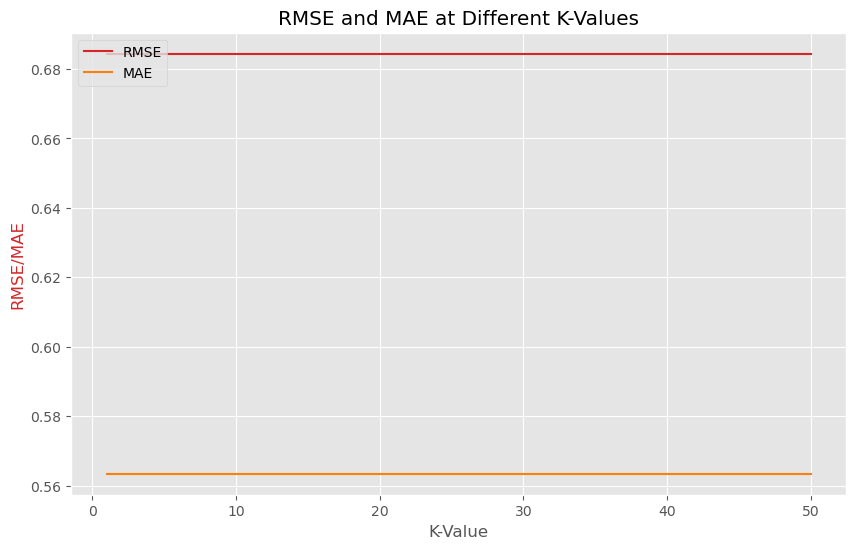

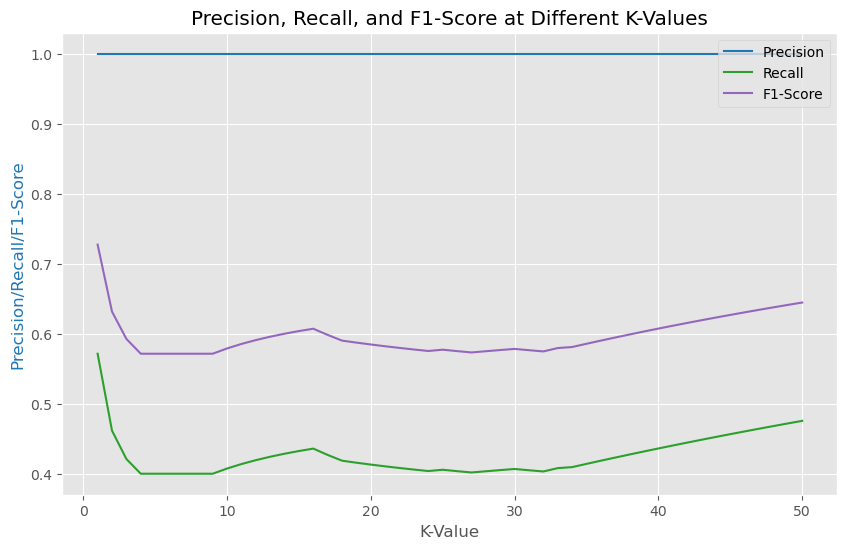

In [167]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import logging
from itertools import product

# Configure logging
logging.basicConfig(level=logging.INFO)

# Constants for easier configuration
MAX_RATINGS = 1000
TFIDF_MAX_FEATURES = 100
TOP_N = 5
THRESHOLD = 4.0
SVD_PARAM_GRID = {
    'n_factors': [50, 100, 150],
    'n_epochs': [10, 20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}
SVD_FIXED_PARAMS = {
    'biased': [True]
}
K_VALUES = list(range(1, 51))

# Load and merge movies and ratings data with essential columns
def load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS):
    try:
        movies_df = pd.read_csv(movies_file, usecols=['movieId', 'title', 'genres'])
        ratings_df = pd.read_csv(ratings_file, usecols=['userId', 'movieId', 'rating']).head(max_ratings)

        movies_df.drop_duplicates(subset=['movieId'], inplace=True)
        ratings_df.drop_duplicates(subset=['userId', 'movieId'], inplace=True)

        movies_df.fillna({'genres': '(no genres listed)'}, inplace=True)
        ratings_df.dropna(subset=['userId', 'movieId', 'rating'], inplace=True)

        merged_df = pd.merge(ratings_df, movies_df, on='movieId')
        logging.info("Data successfully merged and cleaned.")
        return merged_df
    except FileNotFoundError as e:
        logging.error(f"Error: {e}. File not found. Check the file paths.")
        return None
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return None

# Preprocess data by adding one-hot encoding for genres
def preprocess_data(df):
    if 'genres' in df.columns:
        df['genres'] = df['genres'].replace('', '(no genres listed)')
        genres_dummies = df['genres'].str.get_dummies(sep='|')
        df = pd.concat([df, genres_dummies], axis=1)
        logging.info("Genre-based features added.")
    else:
        logging.error("Genres column not available for processing.")
    return df

# Add user-genre interaction features to the dataset
def add_user_genre_features(df):
    if 'userId' in df.columns:
        genre_columns = [col for col in df.columns if col not in ('user_mean_', 'title', 'movieId', 'userId', 'rating') and df[col].dtype in [np.float64, np.int64]]
        
        user_genre_means = df.groupby(['userId'])[genre_columns].mean()
        user_genre_means.columns = [f'user_mean_{col}' for col in user_genre_means.columns]
        
        df = pd.merge(df, user_genre_means, on='userId', how='left')
        logging.info("User-genre interaction features added.")
    else:
        logging.error("UserId column not available for interaction features.")
    return df

# Train and evaluate the SVD model using RandomizedSearchCV
def train_and_evaluate_svd(df):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    trainset, testset = train_test_split(data, test_size=0.25)

    param_grid = {**SVD_PARAM_GRID, **SVD_FIXED_PARAMS}

    random_search = RandomizedSearchCV(
        SVD,
        param_distributions=param_grid,
        n_iter=10,
        measures=['rmse', 'mae'],
        cv=3,
        refit=True,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(data)

    best_params = random_search.best_params['rmse']
    best_model = random_search.best_estimator['rmse']

    predictions = best_model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    logging.info(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")
    logging.info(f"Best Parameters: {best_params}")

    return best_model, testset

# Calculate recommendation metrics (precision, recall, and F1-score)
def calculate_recommendation_metrics(predictions, threshold=THRESHOLD, n=TOP_N):
    def get_top_n(predictions, n=5):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    top_n = get_top_n(predictions, n)
    y_true, y_pred = [], []

    for uid, user_ratings in top_n.items():
        for iid, est_rating, true_rating in user_ratings:
            y_true.append(1 if true_rating >= threshold else 0)
            y_pred.append(1 if est_rating >= threshold else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    logging.info(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    return precision, recall, f1

# Helper function for hybrid recommendations per user
def hybrid_user_recommendation_worker(user_id, df, svd_model, cosine_sim, movie_indices, weight_svd, weight_content, n, min_score):
    svd_recs = [svd_model.predict(user_id, iid) for iid in df['movieId']]
    
    # Ensure unique recommendations per user
    svd_recs = sorted(svd_recs, key=lambda x: x.est, reverse=True)
    svd_recs = list({rec.iid: rec for rec in svd_recs if rec.est >= min_score}.values())

    user_indices = df[df['userId'] == user_id].index
    content_scores = []
    for user_idx in user_indices:
        sim_scores = list(enumerate(cosine_sim[user_idx]))
        sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        content_scores.extend([(df['movieId'][idx], score) for idx, score in sim_scores_sorted[:n]])

    recommendations = []
    seen_movies = set(df[df['userId'] == user_id]['movieId'])  # Movies already rated by the user
    for iid, est_rating in [(rec.iid, rec.est) for rec in svd_recs if rec.iid not in seen_movies]:
        content_score = next((score for mid, score in content_scores if mid == iid), 0)
        combined_score = weight_svd * est_rating + weight_content * content_score
        recommendations.append((iid, combined_score))

    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:n]
    return [(user_id, rec[0], rec[1]) for rec in recommendations]

# Hybrid recommendation function combining SVD and content-based filtering
def hybrid_recommendation_to_screen(df, svd_model, test_users, weight_svd=0.7, weight_content=0.3, n=TOP_N, min_score=3.0, batch_size=2000):
    movie_indices = pd.Series(df.index, index=df['movieId']).drop_duplicates()

    tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['genres'].fillna(''))
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    all_recommendations = []

    for i in range(0, len(test_users), batch_size):
        batch_users = list(test_users)[i:i + batch_size]
        batch_recommendations = Parallel(n_jobs=-1)(
            delayed(hybrid_user_recommendation_worker)(
                user_id, df, svd_model, cosine_sim, movie_indices, weight_svd, weight_content, n, min_score
            )
            for user_id in batch_users
        )
        all_recommendations.extend([item for sublist in batch_recommendations for item in sublist])

    recommendations_df = pd.DataFrame(all_recommendations, columns=['UserID', 'MovieID', 'Score'])
    recommendations_df = recommendations_df.merge(df[['movieId', 'title']].drop_duplicates(), left_on='MovieID', right_on='movieId', how='left')
    recommendations_df.drop(columns=['movieId'], inplace=True)
    return recommendations_df

# Print top N recommendations for sample users
def print_top_n_recommendations(recommendations_df, n=TOP_N):
    unique_users = recommendations_df['UserID'].unique()
    for user_id in unique_users[:5]:
        user_recs = recommendations_df[recommendations_df['UserID'] == user_id]
        print(f"\nTop {n} Recommendations for User {user_id}:")
        for _, row in user_recs.head(n).iterrows():
            print(f"  MovieID: {int(row['MovieID'])}, Title: {row['title']}, Score: {row['Score']:.2f}")

# Plot RMSE, MAE, Precision, Recall, and F1-Score at different K-values
def plot_metrics_at_k(svd_predictions, k_values, threshold=THRESHOLD):
    rmse_values, mae_values = [], []
    precision_values, recall_values, f1_values = [], [], []

    for k in k_values:
        top_n_predictions = calculate_recommendation_metrics(svd_predictions, threshold, k)

        rmse_values.append(accuracy.rmse(svd_predictions, verbose=False))
        mae_values.append(accuracy.mae(svd_predictions, verbose=False))
        precision_values.append(top_n_predictions[0])
        recall_values.append(top_n_predictions[1])
        f1_values.append(top_n_predictions[2])

    # Plot RMSE and MAE
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(k_values, rmse_values, label='RMSE', color='tab:red')
    ax1.plot(k_values, mae_values, label='MAE', color='tab:orange')
    ax1.set_xlabel('K-Value')
    ax1.set_ylabel('RMSE/MAE', color='tab:red')
    ax1.legend(loc='upper left')
    plt.title('RMSE and MAE at Different K-Values')
    plt.show()

    # Plot Precision, Recall, and F1-Score
    fig, ax2 = plt.subplots(figsize=(10, 6))
    ax2.plot(k_values, precision_values, label='Precision', color='tab:blue')
    ax2.plot(k_values, recall_values, label='Recall', color='tab:green')
    ax2.plot(k_values, f1_values, label='F1-Score', color='tab:purple')
    ax2.set_xlabel('K-Value')
    ax2.set_ylabel('Precision/Recall/F1-Score', color='tab:blue')
    ax2.legend(loc='upper right')
    plt.title('Precision, Recall, and F1-Score at Different K-Values')
    plt.show()

# Example Usage
movies_file = '../data/movies.csv'
ratings_file = '../data/ratings.csv'

augmented_ratings_df = load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS)

if augmented_ratings_df is not None:
    augmented_ratings_df = preprocess_data(augmented_ratings_df)
    augmented_ratings_df = add_user_genre_features(augmented_ratings_df)
else:
    logging.error("Data loading failed, preprocessing not performed.")

best_svd_model, svd_testset = train_and_evaluate_svd(augmented_ratings_df)

# Get prediction results and evaluate
svd_predictions = best_svd_model.test(svd_testset)
precision, recall, f1 = calculate_recommendation_metrics(svd_predictions, threshold=THRESHOLD, n=TOP_N)

# Extract unique test users from predictions
test_users = {pred.uid for pred in svd_predictions}

# Generate hybrid recommendations and print them to screen
recommendations_df = hybrid_recommendation_to_screen(augmented_ratings_df, best_svd_model, test_users, n=TOP_N)

# Print top 5 recommendations for 5 sample users
print_top_n_recommendations(recommendations_df, n=TOP_N)

# Plot RMSE, MAE, Precision, Recall, and F1-Score at different K-values
plot_metrics_at_k(svd_predictions, K_VALUES)


# BEST SO FAR

INFO:root:Data successfully merged and cleaned.
INFO:root:Genre-based features added.
INFO:root:User-genre interaction features added.
INFO:root:Best Model (RMSE): RMSE=0.7855, MAE=0.6210
INFO:root:Best Parameters: {'n_factors': 95, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.2, 'biased': True}
INFO:root:Precision: 0.9344, Recall: 0.6429, F1-Score: 0.7617


RMSE: 0.7855
MAE:  0.6210


INFO:root:Precision: 0.9362, Recall: 0.7586, F1-Score: 0.8381
INFO:root:Precision: 0.9341, Recall: 0.7328, F1-Score: 0.8213
INFO:root:Precision: 0.9297, Recall: 0.7041, F1-Score: 0.8013
INFO:root:Precision: 0.9367, Recall: 0.6758, F1-Score: 0.7851
INFO:root:Precision: 0.9344, Recall: 0.6429, F1-Score: 0.7617
INFO:root:Precision: 0.9223, Recall: 0.6189, F1-Score: 0.7407
INFO:root:Precision: 0.9196, Recall: 0.6059, F1-Score: 0.7305
INFO:root:Precision: 0.9174, Recall: 0.5920, F1-Score: 0.7196
INFO:root:Precision: 0.9228, Recall: 0.5815, F1-Score: 0.7134
INFO:root:Precision: 0.9270, Recall: 0.5708, F1-Score: 0.7065
INFO:root:Precision: 0.9303, Recall: 0.5597, F1-Score: 0.6990



Top 5 Recommendations for User 1:
  MovieID: 750, Title: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), Score: 3.51
  MovieID: 68954, Title: Up (2009), Score: 3.49
  MovieID: 4993, Title: Lord of the Rings: The Fellowship of the Ring, The (2001), Score: 3.48
  MovieID: 1250, Title: Bridge on the River Kwai, The (1957), Score: 3.42
  MovieID: 1148, Title: Wallace & Gromit: The Wrong Trousers (1993), Score: 3.41

Top 5 Recommendations for User 2:
  MovieID: 1250, Title: Bridge on the River Kwai, The (1957), Score: 3.19
  MovieID: 1197, Title: Princess Bride, The (1987), Score: 3.17
  MovieID: 553, Title: Tombstone (1993), Score: 3.16
  MovieID: 1213, Title: Goodfellas (1990), Score: 3.14
  MovieID: 1210, Title: Star Wars: Episode VI - Return of the Jedi (1983), Score: 3.13

Top 5 Recommendations for User 4:
  MovieID: 923, Title: Citizen Kane (1941), Score: 3.26
  MovieID: 1270, Title: Back to the Future (1985), Score: 3.23
  MovieID: 356, Title: Forrest Gu

INFO:root:Precision: 0.9262, Recall: 0.5498, F1-Score: 0.6900
INFO:root:Precision: 0.9286, Recall: 0.5366, F1-Score: 0.6801
INFO:root:Precision: 0.9306, Recall: 0.5230, F1-Score: 0.6697
INFO:root:Precision: 0.9325, Recall: 0.5135, F1-Score: 0.6623
INFO:root:Precision: 0.9343, Recall: 0.5098, F1-Score: 0.6596
INFO:root:Precision: 0.9331, Recall: 0.5016, F1-Score: 0.6524
INFO:root:Precision: 0.9318, Recall: 0.4925, F1-Score: 0.6444
INFO:root:Precision: 0.9306, Recall: 0.4855, F1-Score: 0.6381


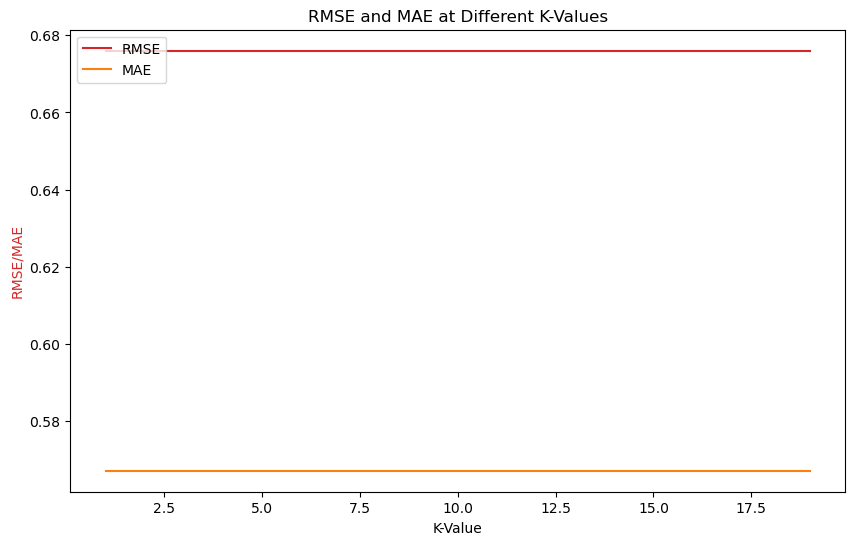

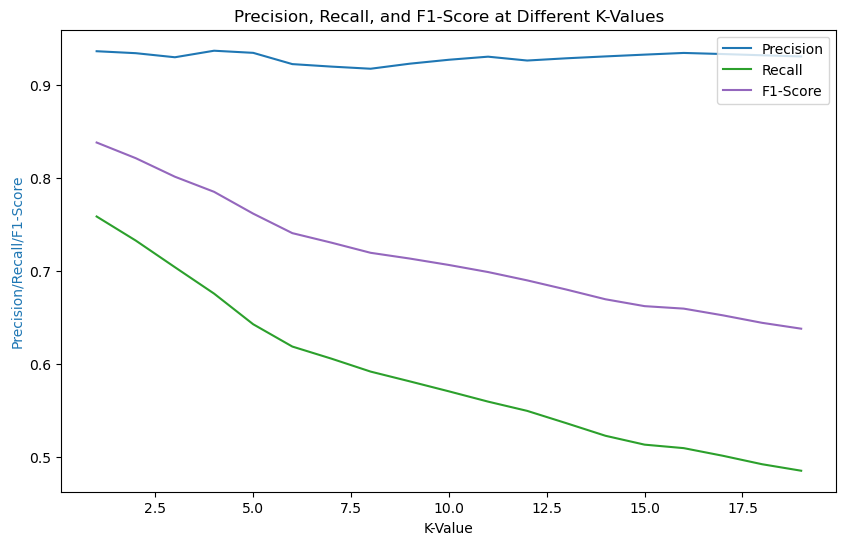

In [3]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Constants for easier configuration
MAX_RATINGS = 10000 # ALL Rating stime oyt
TFIDF_MAX_FEATURES = 100
TOP_N = 5
THRESHOLD = 4.0
SVD_PARAM_GRID = {
    'n_factors': [95, 100, 105],
    'n_epochs': [35, 40, 45],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.2, 0.3, 0.4]
}
SVD_FIXED_PARAMS = {
    'biased': [True]
}
K_VALUES = list(range(1, 20))

BATCH_SIZE = 2000


# Load and merge movies and ratings data with essential columns
def load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS):
    try:
        movies_df = pd.read_csv(movies_file, usecols=['movieId', 'title', 'genres'])
        ratings_df = pd.read_csv(ratings_file, usecols=['userId', 'movieId', 'rating']).head(max_ratings)

        movies_df.drop_duplicates(subset=['movieId'], inplace=True)
        ratings_df.drop_duplicates(subset=['userId', 'movieId'], inplace=True)

        movies_df.fillna({'genres': '(no genres listed)'}, inplace=True)
        ratings_df.dropna(subset=['userId', 'movieId', 'rating'], inplace=True)

        merged_df = pd.merge(ratings_df, movies_df, on='movieId')
        logging.info("Data successfully merged and cleaned.")
        return merged_df
    except FileNotFoundError as e:
        logging.error(f"Error: {e}. File not found. Check the file paths.")
        return None
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return None

# Preprocess data by adding one-hot encoding for genres
def preprocess_data(df):
    if 'genres' in df.columns:
        df['genres'] = df['genres'].replace('', '(no genres listed)')
        genres_dummies = df['genres'].str.get_dummies(sep='|')
        df = pd.concat([df, genres_dummies], axis=1)
        logging.info("Genre-based features added.")
    else:
        logging.error("Genres column not available for processing.")
    return df

# Add user-genre interaction features to the dataset
def add_user_genre_features(df):
    if 'userId' in df.columns:
        genre_columns = [col for col in df.columns if col not in ('user_mean_', 'title', 'movieId', 'userId', 'rating') and df[col].dtype in [np.float64, np.int64]]
        
        user_genre_means = df.groupby(['userId'])[genre_columns].mean()
        user_genre_means.columns = [f'user_mean_{col}' for col in user_genre_means.columns]
        
        df = pd.merge(df, user_genre_means, on='userId', how='left')
        logging.info("User-genre interaction features added.")
    else:
        logging.error("UserId column not available for interaction features.")
    return df

# Train and evaluate the SVD model using RandomizedSearchCV
def train_and_evaluate_svd(df):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    trainset, testset = train_test_split(data, test_size=0.25)

    param_grid = {**SVD_PARAM_GRID, **SVD_FIXED_PARAMS}

    random_search = RandomizedSearchCV(
        SVD,
        param_distributions=param_grid,
        n_iter=10,
        measures=['rmse', 'mae'],
        cv=3,
        refit=True,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(data)

    best_params = random_search.best_params['rmse']
    best_model = random_search.best_estimator['rmse']

    predictions = best_model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    logging.info(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")
    logging.info(f"Best Parameters: {best_params}")

    return best_model, testset

# Calculate recommendation metrics (precision, recall, and F1-score)
def calculate_recommendation_metrics(predictions, threshold=THRESHOLD, n=TOP_N):
    def get_top_n(predictions, n=5):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    top_n = get_top_n(predictions, n)
    y_true, y_pred = [], []

    for uid, user_ratings in top_n.items():
        for iid, est_rating, true_rating in user_ratings:
            y_true.append(1 if true_rating >= threshold else 0)
            y_pred.append(1 if est_rating >= threshold else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    logging.info(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    return precision, recall, f1

# Helper function for hybrid recommendations per user
def hybrid_user_recommendation_worker(user_id, df, svd_model, cosine_sim, movie_indices, weight_svd, weight_content, n, min_score):
    svd_recs = [svd_model.predict(user_id, iid) for iid in df['movieId']]
    
    # Ensure unique recommendations per user
    svd_recs = sorted(svd_recs, key=lambda x: x.est, reverse=True)
    svd_recs = list({rec.iid: rec for rec in svd_recs if rec.est >= min_score}.values())

    seen_movies = set(df[df['userId'] == user_id]['movieId'])  # Movies already rated by the user
    svd_recs = [rec for rec in svd_recs if rec.iid not in seen_movies]

    user_indices = df[df['userId'] == user_id].index
    content_scores = []
    for user_idx in user_indices:
        sim_scores = list(enumerate(cosine_sim[user_idx]))
        sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        content_scores.extend([(df['movieId'][idx], score) for idx, score in sim_scores_sorted[:n]])

    recommendations = []
    for iid, est_rating in [(rec.iid, rec.est) for rec in svd_recs if rec.iid not in seen_movies]:
        content_score = next((score for mid, score in content_scores if mid == iid), 0)
        combined_score = weight_svd * est_rating + weight_content * content_score
        recommendations.append((iid, combined_score))

    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:n]
    return [(user_id, rec[0], rec[1]) for rec in recommendations]

# Hybrid recommendation function combining SVD and content-based filtering
def hybrid_recommendation_to_screen(df, svd_model, test_users, weight_svd=0.7, weight_content=0.3, n=TOP_N, min_score=THRESHOLD, batch_size=BATCH_SIZE):
    movie_indices = pd.Series(df.index, index=df['movieId']).drop_duplicates()

    tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['genres'].fillna(''))
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    all_recommendations = []

    for i in range(0, len(test_users), batch_size):
        batch_users = list(test_users)[i:i + batch_size]
        batch_recommendations = Parallel(n_jobs=-1)(
            delayed(hybrid_user_recommendation_worker)(
                user_id, df, svd_model, cosine_sim, movie_indices, weight_svd, weight_content, n, min_score
            )
            for user_id in batch_users
        )
        all_recommendations.extend([item for sublist in batch_recommendations for item in sublist])

    recommendations_df = pd.DataFrame(all_recommendations, columns=['UserID', 'MovieID', 'Score'])
    recommendations_df = recommendations_df.merge(df[['movieId', 'title']].drop_duplicates(), left_on='MovieID', right_on='movieId', how='left')
    recommendations_df.drop(columns=['movieId'], inplace=True)
    return recommendations_df

# Print top N recommendations for sample users
def print_top_n_recommendations(recommendations_df, n=TOP_N):
    unique_users = recommendations_df['UserID'].unique()
    for user_id in unique_users[:5]:
        user_recs = recommendations_df[recommendations_df['UserID'] == user_id]
        print(f"\nTop {n} Recommendations for User {user_id}:")
        for _, row in user_recs.head(n).iterrows():
            print(f"  MovieID: {int(row['MovieID'])}, Title: {row['title']}, Score: {row['Score']:.2f}")

# Plot RMSE, MAE, Precision, Recall, and F1-Score at different K-values
def plot_metrics_at_k(svd_predictions, k_values, threshold=THRESHOLD):
    rmse_values, mae_values = [], []
    precision_values, recall_values, f1_values = [], [], []

    for k in k_values:
        precision, recall, f1 = calculate_recommendation_metrics(svd_predictions, threshold, k)
        filtered_predictions = [pred for pred in svd_predictions if pred.est >= threshold]
        rmse_values.append(accuracy.rmse(filtered_predictions, verbose=False))
        mae_values.append(accuracy.mae(filtered_predictions, verbose=False))
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

    # Plot RMSE and MAE
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(k_values, rmse_values, label='RMSE', color='tab:red')
    ax1.plot(k_values, mae_values, label='MAE', color='tab:orange')
    ax1.set_xlabel('K-Value')
    ax1.set_ylabel('RMSE/MAE', color='tab:red')
    ax1.legend(loc='upper left')
    plt.title('RMSE and MAE at Different K-Values')
    plt.show()

    # Plot Precision, Recall, and F1-Score
    fig, ax2 = plt.subplots(figsize=(10, 6))
    ax2.plot(k_values, precision_values, label='Precision', color='tab:blue')
    ax2.plot(k_values, recall_values, label='Recall', color='tab:green')
    ax2.plot(k_values, f1_values, label='F1-Score', color='tab:purple')
    ax2.set_xlabel('K-Value')
    ax2.set_ylabel('Precision/Recall/F1-Score', color='tab:blue')
    ax2.legend(loc='upper right')
    plt.title('Precision, Recall, and F1-Score at Different K-Values')
    plt.show()

# Example Usage
movies_file = '../data/movies.csv'
ratings_file = '../data/ratings.csv'

augmented_ratings_df = load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS)

if augmented_ratings_df is not None:
    augmented_ratings_df = preprocess_data(augmented_ratings_df)
    augmented_ratings_df = add_user_genre_features(augmented_ratings_df)
else:
    logging.error("Data loading failed, preprocessing not performed.")

best_svd_model, svd_testset = train_and_evaluate_svd(augmented_ratings_df)

# Get prediction results and evaluate
svd_predictions = best_svd_model.test(svd_testset)
precision, recall, f1 = calculate_recommendation_metrics(svd_predictions, threshold=THRESHOLD, n=TOP_N)

# Extract unique test users from predictions
test_users = {pred.uid for pred in svd_predictions}

# Generate hybrid recommendations and print them to screen
recommendations_df = hybrid_recommendation_to_screen(augmented_ratings_df, best_svd_model, test_users, n=TOP_N)

# Print top 5 recommendations for 5 sample users
print_top_n_recommendations(recommendations_df, n=TOP_N)

# Plot RMSE, MAE, Precision, Recall, and F1-Score at different K-values
plot_metrics_at_k(svd_predictions, K_VALUES)


# FULL CODE AGAIN - TEST RUNS

In [32]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)

# Constants for easier configuration
MAX_RATINGS = 10000
TFIDF_MAX_FEATURES = 100
TOP_N = 5
THRESHOLD = 4.0
SVD_PARAM_GRID = {
    'n_factors': [100, 110, 120],
    'n_epochs': [40, 50, 60],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}
SVD_FIXED_PARAMS = {
    'biased': [True]
}
K_VALUES = list(range(1, 51))

# Load and merge movies and ratings data with essential columns
def load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS):
    try:
        movies_df = pd.read_csv(movies_file, usecols=['movieId', 'title', 'genres'])
        ratings_df = pd.read_csv(ratings_file, usecols=['userId', 'movieId', 'rating']).head(max_ratings)

        movies_df.drop_duplicates(subset=['movieId'], inplace=True)
        ratings_df.drop_duplicates(subset=['userId', 'movieId'], inplace=True)

        movies_df.fillna({'genres': '(no genres listed)'}, inplace=True)
        ratings_df.dropna(subset=['userId', 'movieId', 'rating'], inplace=True)

        merged_df = pd.merge(ratings_df, movies_df, on='movieId')
        logging.info("Data successfully merged and cleaned.")
        return merged_df
    except FileNotFoundError as e:
        logging.error(f"Error: {e}. File not found. Check the file paths.")
        return None
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        return None

# Preprocess data by adding one-hot encoding for genres
def preprocess_data(df):
    if 'genres' in df.columns:
        df['genres'] = df['genres'].replace('', '(no genres listed)')
        genres_dummies = df['genres'].str.get_dummies(sep='|')
        df = pd.concat([df, genres_dummies], axis=1)
        logging.info("Genre-based features added.")
    else:
        logging.error("Genres column not available for processing.")
    return df

# Add user-genre interaction features to the dataset
def add_user_genre_features(df):
    if 'userId' in df.columns:
        genre_columns = [col for col in df.columns if col not in ('user_mean_', 'title', 'movieId', 'userId', 'rating') and df[col].dtype in [np.float64, np.int64]]
        
        user_genre_means = df.groupby(['userId'])[genre_columns].mean()
        user_genre_means.columns = [f'user_mean_{col}' for col in user_genre_means.columns]
        
        df = pd.merge(df, user_genre_means, on='userId', how='left')
        logging.info("User-genre interaction features added.")
    else:
        logging.error("UserId column not available for interaction features.")
    return df

# Train and evaluate the SVD model using RandomizedSearchCV
def train_and_evaluate_svd(df):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

    trainset, testset = train_test_split(data, test_size=0.25)

    param_grid = {**SVD_PARAM_GRID, **SVD_FIXED_PARAMS}

    random_search = RandomizedSearchCV(
        SVD,
        param_distributions=param_grid,
        n_iter=10,
        measures=['rmse', 'mae'],
        cv=3,
        refit=True,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(data)

    best_params = random_search.best_params['rmse']
    best_model = random_search.best_estimator['rmse']

    predictions = best_model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    logging.info(f"Best Model (RMSE): RMSE={rmse:.4f}, MAE={mae:.4f}")
    logging.info(f"Best Parameters: {best_params}")

    return best_model, testset

# Calculate recommendation metrics (precision, recall, and F1-score)
def calculate_recommendation_metrics(predictions, threshold=THRESHOLD, n=TOP_N):
    def get_top_n(predictions, n=5):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    top_n = get_top_n(predictions, n)
    y_true, y_pred = [], []

    for uid, user_ratings in top_n.items():
        for iid, est_rating, true_rating in user_ratings:
            y_true.append(1 if true_rating >= threshold else 0)
            y_pred.append(1 if est_rating >= threshold else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    logging.info(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    return precision, recall, f1

# Helper function for hybrid recommendations per user
def hybrid_user_recommendation_worker(user_id, df, svd_model, cosine_sim, movie_indices, weight_svd, weight_content, n, min_score):
    svd_recs = [svd_model.predict(user_id, iid) for iid in df['movieId']]
    
    # Ensure unique recommendations per user
    svd_recs = sorted(svd_recs, key=lambda x: x.est, reverse=True)
    svd_recs = list({rec.iid: rec for rec in svd_recs if rec.est >= min_score}.values())

    seen_movies = set(df[df['userId'] == user_id]['movieId'])  # Movies already rated by the user
    svd_recs = [rec for rec in svd_recs if rec.iid not in seen_movies]

    user_indices = df[df['userId'] == user_id].index
    content_scores = []
    for user_idx in user_indices:
        sim_scores = list(enumerate(cosine_sim[user_idx]))
        sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        content_scores.extend([(df['movieId'][idx], score) for idx, score in sim_scores_sorted[:n]])

    recommendations = []
    for iid, est_rating in [(rec.iid, rec.est) for rec in svd_recs if rec.iid not in seen_movies]:
        content_score = next((score for mid, score in content_scores if mid == iid), 0)
        combined_score = weight_svd * est_rating + weight_content * content_score
        recommendations.append((iid, combined_score))

    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:n]
    return [(user_id, rec[0], rec[1]) for rec in recommendations]

# Hybrid recommendation function combining SVD and content-based filtering
def hybrid_recommendation_to_screen(df, svd_model, test_users, weight_svd=0.7, weight_content=0.3, n=TOP_N, min_score=3.0, batch_size=2000):
    movie_indices = pd.Series(df.index, index=df['movieId']).drop_duplicates()

    tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['genres'].fillna(''))
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    all_recommendations = []

    for i in range(0, len(test_users), batch_size):
        batch_users = list(test_users)[i:i + batch_size]
        batch_recommendations = Parallel(n_jobs=-1)(
            delayed(hybrid_user_recommendation_worker)(
                user_id, df, svd_model, cosine_sim, movie_indices, weight_svd, weight_content, n, min_score
            )
            for user_id in batch_users
        )
        all_recommendations.extend([item for sublist in batch_recommendations for item in sublist])

    recommendations_df = pd.DataFrame(all_recommendations, columns=['UserID', 'MovieID', 'Score'])
    recommendations_df = recommendations_df.merge(df[['movieId', 'title']].drop_duplicates(), left_on='MovieID', right_on='movieId', how='left')
    recommendations_df.drop(columns=['movieId'], inplace=True)
    return recommendations_df


# Example Usage
movies_file = '../data/movies.csv'
ratings_file = '../data/ratings.csv'

augmented_ratings_df = load_and_merge_data(movies_file, ratings_file, max_ratings=MAX_RATINGS)

if augmented_ratings_df is not None:
    augmented_ratings_df = preprocess_data(augmented_ratings_df)
    augmented_ratings_df = add_user_genre_features(augmented_ratings_df)
else:
    logging.error("Data loading failed, preprocessing not performed.")

best_svd_model, svd_testset = train_and_evaluate_svd(augmented_ratings_df)

# Get prediction results and evaluate
svd_predictions = best_svd_model.test(svd_testset)
precision, recall, f1 = calculate_recommendation_metrics(svd_predictions, threshold=THRESHOLD, n=TOP_N)

# Extract unique test users from predictions
test_users = {pred.uid for pred in svd_predictions}

# Generate hybrid recommendations and print them to screen
recommendations_df = hybrid_recommendation_to_screen(augmented_ratings_df, best_svd_model, test_users, n=TOP_N)



INFO:root:Data successfully merged and cleaned.
INFO:root:Genre-based features added.
INFO:root:User-genre interaction features added.
INFO:root:Best Model (RMSE): RMSE=0.7349, MAE=0.5816
INFO:root:Best Parameters: {'n_factors': 120, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.2, 'biased': True}
INFO:root:Precision: 0.9433, Recall: 0.6512, F1-Score: 0.7705


RMSE: 0.7349
MAE:  0.5816


INFO:root:Precision: 0.9792, Recall: 0.7231, F1-Score: 0.8319
INFO:root:Precision: 0.9451, Recall: 0.6992, F1-Score: 0.8037
INFO:root:Precision: 0.9542, Recall: 0.6906, F1-Score: 0.8013
INFO:root:Precision: 0.9518, Recall: 0.6870, F1-Score: 0.7980
INFO:root:Precision: 0.9433, Recall: 0.6512, F1-Score: 0.7705
INFO:root:Precision: 0.9500, Recall: 0.6411, F1-Score: 0.7656
INFO:root:Precision: 0.9467, Recall: 0.6381, F1-Score: 0.7624
INFO:root:Precision: 0.9508, Recall: 0.6291, F1-Score: 0.7572
INFO:root:Precision: 0.9464, Recall: 0.6148, F1-Score: 0.7454
INFO:root:Precision: 0.9458, Recall: 0.6026, F1-Score: 0.7361
INFO:root:Precision: 0.9419, Recall: 0.5935, F1-Score: 0.7282
INFO:root:Precision: 0.9444, Recall: 0.5896, F1-Score: 0.7260
INFO:root:Precision: 0.9405, Recall: 0.5756, F1-Score: 0.7141
INFO:root:Precision: 0.9308, Recall: 0.5647, F1-Score: 0.7029
INFO:root:Precision: 0.9302, Recall: 0.5550, F1-Score: 0.6952
INFO:root:Precision: 0.9319, Recall: 0.5490, F1-Score: 0.6909
INFO:roo


Top 5 Recommendations for User 1:
  MovieID: 750, Title: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), Score: 3.51
  MovieID: 68954, Title: Up (2009), Score: 3.48
  MovieID: 70946, Title: Troll 2 (1990), Score: 3.47
  MovieID: 1250, Title: Bridge on the River Kwai, The (1957), Score: 3.47
  MovieID: 4993, Title: Lord of the Rings: The Fellowship of the Ring, The (2001), Score: 3.46

Top 5 Recommendations for User 2:
  MovieID: 1197, Title: Princess Bride, The (1987), Score: 3.21
  MovieID: 1250, Title: Bridge on the River Kwai, The (1957), Score: 3.18
  MovieID: 162, Title: Crumb (1994), Score: 3.17
  MovieID: 110, Title: Braveheart (1995), Score: 3.17
  MovieID: 2858, Title: American Beauty (1999), Score: 3.17

Top 5 Recommendations for User 3:
  MovieID: 260, Title: Star Wars: Episode IV - A New Hope (1977), Score: 2.63
  MovieID: 2300, Title: Producers, The (1968), Score: 2.61
  MovieID: 1240, Title: Terminator, The (1984), Score: 2.56
  MovieID: 1953

INFO:root:Precision: 0.9324, Recall: 0.5135, F1-Score: 0.6623
INFO:root:Precision: 0.9310, Recall: 0.5082, F1-Score: 0.6575
INFO:root:Precision: 0.9297, Recall: 0.5049, F1-Score: 0.6544
INFO:root:Precision: 0.9262, Recall: 0.5006, F1-Score: 0.6499
INFO:root:Precision: 0.9270, Recall: 0.4982, F1-Score: 0.6481
INFO:root:Precision: 0.9256, Recall: 0.4936, F1-Score: 0.6438
INFO:root:Precision: 0.9262, Recall: 0.4914, F1-Score: 0.6421
INFO:root:Precision: 0.9246, Recall: 0.4875, F1-Score: 0.6384
INFO:root:Precision: 0.9251, Recall: 0.4848, F1-Score: 0.6362
INFO:root:Precision: 0.9232, Recall: 0.4800, F1-Score: 0.6317
INFO:root:Precision: 0.9236, Recall: 0.4770, F1-Score: 0.6291
INFO:root:Precision: 0.9239, Recall: 0.4745, F1-Score: 0.6270
INFO:root:Precision: 0.9242, Recall: 0.4715, F1-Score: 0.6245
INFO:root:Precision: 0.9245, Recall: 0.4682, F1-Score: 0.6216
INFO:root:Precision: 0.9248, Recall: 0.4663, F1-Score: 0.6200
INFO:root:Precision: 0.9252, Recall: 0.4635, F1-Score: 0.6176
INFO:roo

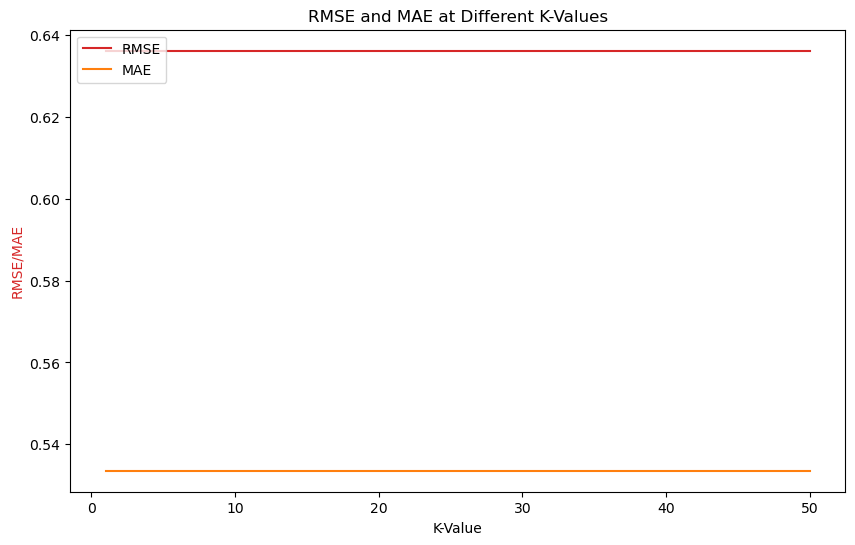

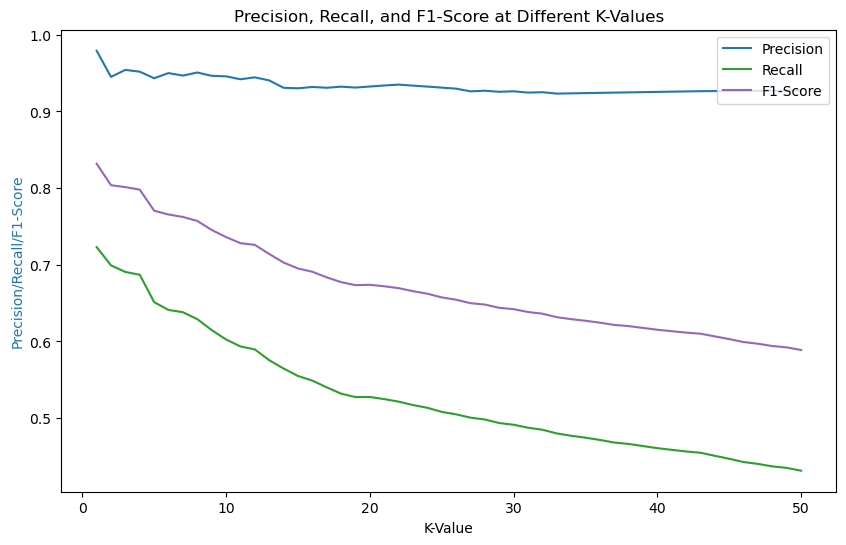

In [34]:
# Print top N recommendations for sample users
def print_top_n_recommendations(recommendations_df, n=TOP_N):
    unique_users = recommendations_df['UserID'].unique()
    for user_id in unique_users[:5]:
        user_recs = recommendations_df[recommendations_df['UserID'] == user_id]
        print(f"\nTop {n} Recommendations for User {user_id}:")
        for _, row in user_recs.head(n).iterrows():
            print(f"  MovieID: {int(row['MovieID'])}, Title: {row['title']}, Score: {row['Score']:.2f}")

# Plot RMSE, MAE, Precision, Recall, and F1-Score at different K-values
def plot_metrics_at_k(svd_predictions, k_values, threshold=THRESHOLD):
    rmse_values, mae_values = [], []
    precision_values, recall_values, f1_values = [], [], []

    for k in k_values:
        precision, recall, f1 = calculate_recommendation_metrics(svd_predictions, threshold, k)
        filtered_predictions = [pred for pred in svd_predictions if pred.est >= threshold]
        rmse_values.append(accuracy.rmse(filtered_predictions, verbose=False))
        mae_values.append(accuracy.mae(filtered_predictions, verbose=False))
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

    # Plot RMSE and MAE
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(k_values, rmse_values, label='RMSE', color='tab:red')
    ax1.plot(k_values, mae_values, label='MAE', color='tab:orange')
    ax1.set_xlabel('K-Value')
    ax1.set_ylabel('RMSE/MAE', color='tab:red')
    ax1.legend(loc='upper left')
    plt.title('RMSE and MAE at Different K-Values')
    plt.show()

    # Plot Precision, Recall, and F1-Score
    fig, ax2 = plt.subplots(figsize=(10, 6))
    ax2.plot(k_values, precision_values, label='Precision', color='tab:blue')
    ax2.plot(k_values, recall_values, label='Recall', color='tab:green')
    ax2.plot(k_values, f1_values, label='F1-Score', color='tab:purple')
    ax2.set_xlabel('K-Value')
    ax2.set_ylabel('Precision/Recall/F1-Score', color='tab:blue')
    ax2.legend(loc='upper right')
    plt.title('Precision, Recall, and F1-Score at Different K-Values')
    plt.show()

    
# Print top 5 recommendations for 5 sample users
print_top_n_recommendations(recommendations_df, n=TOP_N)

# Plot RMSE, MAE, Precision, Recall, and F1-Score at different K-values
plot_metrics_at_k(svd_predictions, K_VALUES)

# Model Evaluation

In [ ]:
## prior

In [ ]:
'''

# Actual metrics obtained from the Full Model
model_metrics = {
    'RMSE': rmse,    # As reported
    'MAE': mae,     # As reported
    'Precision': precision,  # As reported
    'Recall': recall,     # As reported
    'F1 Score': f1    # As reported
}

# Ranges for industry standards (min and max)
industry_ranges = {
    'RMSE': (0.85, 0.95),       # Min and max RMSE in industry
    'MAE': (0.70, 0.75),         # Min and max MAE in industry
    'Precision': (0.70, 0.80),  # Min and max precision in industry
    'Recall': (0.10, 0.40),     # Min and max recall in industry
    'F1 Score': (0.30, 0.50),   # Min and max F1 score in industry
}

metrics = list(model_metrics.keys())
x = np.arange(len(metrics))  # label locations
bar_width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bars for model metrics
ax.bar(x, [model_metrics[metric] for metric in metrics], width=bar_width, color='lightblue', label='Model Metrics')

# Calculate means and error margins for industry standards
industry_means = [(industry_ranges[metric][0] + industry_ranges[metric][1]) / 2 for metric in metrics]
industry_errors = [(industry_ranges[metric][1] - industry_ranges[metric][0]) / 2 for metric in metrics]

# Adding error bars to indicate the range of industry standards
ax.errorbar(x, industry_means, yerr=industry_errors, fmt='o', color='red', capsize=5, label='Industry Range')

# Adding labels, title, and custom x-axis tick labels
ax.set_ylabel('Values')
ax.set_title('Model Metrics vs Industry Ranges')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)  # Setting the y-limit to encompass typical ranges for these metrics
ax.legend()

plt.tight_layout()
plt.show()

'''


## Top-N, Precision-Recall at K

In [ ]:
## PRIOR

## Additional Metrics

In [3]:
from sklearn.metrics import ndcg_score, average_precision_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import Counter, defaultdict
from sklearn.metrics.pairwise import linear_kernel

# Function to get Top-N recommendations
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

# Function to calculate Mean Average Precision (MAP) and NDCG
def calculate_map_ndcg(predictions, threshold=4.0, k=5):
    top_n = get_top_n(predictions, n=k)
    y_true_all, y_score_all = [], []

    for uid, user_ratings in top_n.items():
        y_true = [1 if rating[2] >= threshold else 0 for rating in user_ratings]
        y_score = [rating[1] for rating in user_ratings]
        if len(y_true) > 0 and sum(y_true) > 0:
            y_true_all.append(y_true)
            y_score_all.append(y_score)

    # Calculate MAP
    map_score = np.mean([average_precision_score(y_true, y_score) for y_true, y_score in zip(y_true_all, y_score_all)])

    # Calculate NDCG
    ndcg = np.mean([ndcg_score([y_true], [y_score], k=k) for y_true, y_score in zip(y_true_all, y_score_all)])

    print(f"MAP: {map_score:.4f}, NDCG: {ndcg:.4f}")
    return map_score, ndcg

# Function to calculate Precision, Recall, and F1-Score at k
def precision_recall_f1_at_k(predictions, k=5, threshold=4.0):
    top_n = get_top_n(predictions, n=k)
    y_true, y_pred = [], []

    for uid, user_ratings in top_n.items():
        for iid, est_rating, true_rating in user_ratings:
            y_true.append(1 if true_rating >= threshold else 0)
            y_pred.append(1 if est_rating >= threshold else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Precision@{k}: {precision:.4f}, Recall@{k}: {recall:.4f}, F1-Score@{k}: {f1:.4f}")
    return precision, recall, f1

# Function to calculate Mean Reciprocal Rank (MRR)
def calculate_mrr(predictions, threshold=4.0):
    top_n = get_top_n(predictions, n=5)
    mrrs = []

    for uid, user_ratings in top_n.items():
        y_true = [1 if rating[2] >= threshold else 0 for rating in user_ratings]
        try:
            first_relevant = y_true.index(1) + 1
            mrrs.append(1 / first_relevant)
        except ValueError:
            mrrs.append(0)

    mean_mrr = np.mean(mrrs)
    print(f"MRR: {mean_mrr:.4f}")
    return mean_mrr

# Function to calculate ROC-AUC Score
def calculate_roc_auc(predictions, threshold=4.0):
    top_n = get_top_n(predictions, n=5)
    y_true, y_score = [], []

    for uid, user_ratings in top_n.items():
        for iid, est_rating, true_rating in user_ratings:
            y_true.append(1 if true_rating >= threshold else 0)
            y_score.append(est_rating)

    roc_auc = roc_auc_score(y_true, y_score)
    print(f"ROC-AUC: {roc_auc:.4f}")
    return roc_auc

# Function to calculate novelty
def calculate_novelty(predictions, df, k=5):
    item_popularity = Counter(df['movieId'])
    total_ratings = len(df)
    top_n = get_top_n(predictions, n=k)

    # Sort predictions by estimated rating and calculate novelty
    novelty_scores = []
    for uid, user_ratings in top_n.items():
        novelty = np.mean([-np.log2(item_popularity[iid] / total_ratings) for iid, _, _ in user_ratings])
        novelty_scores.append(novelty)

    mean_novelty = np.mean(novelty_scores)
    print(f"Novelty: {mean_novelty:.4f}")
    return mean_novelty

# Function to calculate serendipity
def calculate_serendipity(predictions, user_histories, k=5):
    def is_serendipitous(iid, user_history):
        return iid not in user_history

    top_n = get_top_n(predictions, n=k)

    # Sort predictions by estimated rating and calculate serendipity
    serendipity_scores = []
    for uid, user_ratings in top_n.items():
        serendipity = np.mean([1 if is_serendipitous(iid, user_histories[uid]) else 0 for iid, _, _ in user_ratings])
        serendipity_scores.append(serendipity)

    mean_serendipity = np.mean(serendipity_scores)
    print(f"Serendipity: {mean_serendipity:.4f}")
    return mean_serendipity

# Function to calculate diversity
def calculate_diversity(predictions, tfidf_matrix, k=5):
    top_n = get_top_n(predictions, n=k)

    # Sort predictions by estimated rating and calculate diversity
    diversity_scores = []
    for uid, user_ratings in top_n.items():
        indices = [int(idx) for idx, _, _ in user_ratings]

        if len(indices) > 1:
            pairwise_similarities = linear_kernel(tfidf_matrix[indices], tfidf_matrix[indices])
            pairwise_diversities = 1 - pairwise_similarities
            diversity = np.mean(pairwise_diversities[np.triu_indices(len(indices), 1)])
            diversity_scores.append(diversity)
        else:
            diversity_scores.append(1)

    mean_diversity = np.mean(diversity_scores)
    print(f"Diversity: {mean_diversity:.4f}")
    return mean_diversity

# Function to calculate personalization
def calculate_personalization(predictions, k=5):
    top_n = get_top_n(predictions, n=k)

    # Sort predictions by estimated rating and calculate personalization
    personalization_scores = []
    all_pairs = []

    for uid, user_ratings in top_n.items():
        items = [iid for iid, _, _ in user_ratings]
        all_pairs.append(set(items))

    for i in range(len(all_pairs)):
        for j in range(i + 1, len(all_pairs)):
            personalization = 1 - len(all_pairs[i] & all_pairs[j]) / len(all_pairs[i] | all_pairs[j])
            personalization_scores.append(personalization)

    mean_personalization = np.mean(personalization_scores)
    print(f"Personalization: {mean_personalization:.4f}")
    return mean_personalization

# Function to calculate coverage
def calculate_coverage(predictions, total_items, k=5):
    top_n = get_top_n(predictions, n=k)

    # Sort predictions by estimated rating and calculate coverage
    recommended_items = set()
    for uid, user_ratings in top_n.items():
        recommended_items.update([iid for iid, _, _ in user_ratings])

    item_coverage = len(recommended_items) / total_items
    print(f"Coverage: {item_coverage:.4f}")
    return item_coverage

# Example Usage for All Metrics
total_items = augmented_ratings_df['movieId'].nunique()
tfidf = TfidfVectorizer(max_features=50, stop_words='english')  # Reduced to 50 temporarily
tfidf_matrix = tfidf.fit_transform(augmented_ratings_df['genres'].fillna(''))
user_histories = augmented_ratings_df.groupby('userId')['movieId'].apply(list).to_dict()

# Calculate Metrics
calculate_map_ndcg(svd_predictions, threshold=4.0, k=5)
precision_recall_f1_at_k(svd_predictions, k=5, threshold=4.0)
calculate_mrr(svd_predictions, threshold=4.0)
calculate_roc_auc(svd_predictions, threshold=4.0)
calculate_novelty(svd_predictions, augmented_ratings_df, k=5)
calculate_serendipity(svd_predictions, user_histories, k=5)
calculate_diversity(svd_predictions, tfidf_matrix, k=5)
calculate_personalization(svd_predictions, k=5)
calculate_coverage(svd_predictions, total_items, k=5)


ValueError: Computing NDCG is only meaningful when there is more than 1 document. Got 1 instead.

In [5]:
import math

def calculate_dcg(rel, k):
    dcg = 0
    for i in range(min(k, len(rel))):
        dcg += rel[i] / (math.log2(i + 2))
    return dcg

def calculate_idcg(rel, k):
    rel_sorted = sorted(rel, reverse=True)  # Sort relevance scores in descending order
    return calculate_dcg(rel_sorted, k)

# Example relevance scores and depth of evaluation
rel = [0, .5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]  # Relevance scores of recommended items
k = 10  # Depth of evaluation

# Calculate DCG and IDCG
dcg = calculate_dcg(rel, k)
idcg = calculate_idcg(rel, k)

print("DCG:", dcg)
print("IDCG:", idcg)

# Calculate NDCG (Normalized Discounted Cumulative Gain)
ndcg = dcg / idcg
print("NDCG:", ndcg)



DCG: 7.734742065971428
IDCG: 14.983054624470299
NDCG: 0.5162326548111932


In [7]:
from sklearn.metrics import ndcg_score, average_precision_score
from collections import Counter, defaultdict
from sklearn.metrics.pairwise import linear_kernel

# Function to calculate Mean Average Precision (MAP) and NDCG
def calculate_map_ndcg(predictions, threshold=4.0, k=5):
    def get_top_n(predictions, n=5):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    top_n = get_top_n(predictions, n=k)
    y_true_all, y_score_all = [], []

    for uid, user_ratings in top_n.items():
        y_true = [1 if rating[2] >= threshold else 0 for rating in user_ratings]
        y_score = [rating[1] for rating in user_ratings]
        if len(y_true) > 0 and sum(y_true) > 0:
            y_true_all.append(y_true)
            y_score_all.append(y_score)

    # Calculate MAP
    map_score = np.mean([average_precision_score(y_true, y_score) for y_true, y_score in zip(y_true_all, y_score_all)])

    # Calculate NDCG
    ndcg = np.mean([ndcg_score([y_true], [y_score], k=k) for y_true, y_score in zip(y_true_all, y_score_all)])

    print(f"MAP: {map_score:.4f}, NDCG: {ndcg:.4f}")
    return map_score, ndcg

# Function to calculate Mean Reciprocal Rank (MRR)
def calculate_mrr(predictions, threshold=4.0):
    def get_top_n(predictions, n=5):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    top_n = get_top_n(predictions, n=5)
    mrrs = []

    for uid, user_ratings in top_n.items():
        y_true = [1 if rating[2] >= threshold else 0 for rating in user_ratings]
        try:
            first_relevant = y_true.index(1) + 1
            mrrs.append(1 / first_relevant)
        except ValueError:
            mrrs.append(0)

    mean_mrr = np.mean(mrrs)
    print(f"MRR: {mean_mrr:.4f}")
    return mean_mrr

# Function to calculate ROC-AUC Score
from sklearn.metrics import roc_auc_score

def calculate_roc_auc(predictions, threshold=4.0):
    def get_top_n(predictions, n=5):
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            top_n[uid].append((iid, est, true_r))
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
        return top_n

    top_n = get_top_n(predictions, n=5)
    y_true, y_score = [], []

    for uid, user_ratings in top_n.items():
        for iid, est_rating, true_rating in user_ratings:
            y_true.append(1 if true_rating >= threshold else 0)
            y_score.append(est_rating)

    roc_auc = roc_auc_score(y_true, y_score)
    print(f"ROC-AUC: {roc_auc:.4f}")
    return roc_auc

# Function to calculate novelty
def calculate_novelty(predictions, df, k=5):
    item_popularity = Counter(df['movieId'])
    total_ratings = len(df)
    top_n = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort predictions by estimated rating and calculate novelty
    novelty_scores = []
    for uid, user_ratings in top_n.items():
        user_ratings = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:k]
        novelty = np.mean([-np.log2(item_popularity[iid] / total_ratings) for iid, _ in user_ratings])
        novelty_scores.append(novelty)

    mean_novelty = np.mean(novelty_scores)
    print(f"Novelty: {mean_novelty:.4f}")
    return mean_novelty

# Function to calculate serendipity
def calculate_serendipity(predictions, user_histories, k=5):
    def is_serendipitous(iid, user_history):
        return iid not in user_history

    top_n = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort predictions by estimated rating and calculate serendipity
    serendipity_scores = []
    for uid, user_ratings in top_n.items():
        user_ratings = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:k]
        serendipity = np.mean([1 if is_serendipitous(iid, user_histories[uid]) else 0 for iid, _ in user_ratings])
        serendipity_scores.append(serendipity)

    mean_serendipity = np.mean(serendipity_scores)
    print(f"Serendipity: {mean_serendipity:.4f}")
    return mean_serendipity

# Function to calculate diversity
def calculate_diversity(predictions, tfidf_matrix, k=5):
    top_n = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort predictions by estimated rating and calculate diversity
    diversity_scores = []
    for uid, user_ratings in top_n.items():
        user_ratings = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:k]
        indices = [int(idx) for idx, _ in user_ratings]

        if len(indices) > 1:
            pairwise_similarities = linear_kernel(tfidf_matrix[indices], tfidf_matrix[indices])
            pairwise_diversities = 1 - pairwise_similarities
            diversity = np.mean(pairwise_diversities[np.triu_indices(len(indices), 1)])
            diversity_scores.append(diversity)
        else:
            diversity_scores.append(1)

    mean_diversity = np.mean(diversity_scores)
    print(f"Diversity: {mean_diversity:.4f}")
    return mean_diversity

# Function to calculate personalization
def calculate_personalization(predictions, k=5):
    top_n = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort predictions by estimated rating and calculate personalization
    personalization_scores = []
    all_pairs = []

    for uid, user_ratings in top_n.items():
        user_ratings = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:k]
        items = [iid for iid, _ in user_ratings]
        all_pairs.append(set(items))

    for i in range(len(all_pairs)):
        for j in range(i + 1, len(all_pairs)):
            personalization = 1 - len(all_pairs[i] & all_pairs[j]) / len(all_pairs[i] | all_pairs[j])
            personalization_scores.append(personalization)

    mean_personalization = np.mean(personalization_scores)
    print(f"Personalization: {mean_personalization:.4f}")
    return mean_personalization

# Function to calculate coverage
def calculate_coverage(predictions, total_items, k=5):
    top_n = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort predictions by estimated rating and calculate coverage
    recommended_items = set()
    for uid, user_ratings in top_n.items():
        user_ratings = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:k]
        recommended_items.update([iid for iid, _ in user_ratings])

    item_coverage = len(recommended_items) / total_items
    print(f"Coverage: {item_coverage:.4f}")
    return item_coverage

# Example Usage for All Metrics
total_items = augmented_ratings_df['movieId'].nunique()
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = tfidf.fit_transform(augmented_ratings_df['genres'].fillna(''))
user_histories = augmented_ratings_df.groupby('userId')['movieId'].apply(list).to_dict()

# Calculate Metrics
calculate_map_ndcg(svd_predictions, threshold=4.0, k=5)
calculate_mrr(svd_predictions, threshold=4.0)
calculate_roc_auc(svd_predictions, threshold=4.0)
calculate_novelty(svd_predictions, augmented_ratings_df, k=5)
calculate_serendipity(svd_predictions, user_histories, k=5)
calculate_diversity(svd_predictions, tfidf_matrix, k=5)
calculate_personalization(svd_predictions, k=5)
calculate_coverage(svd_predictions, total_items, k=5)


ValueError: Computing NDCG is only meaningful when there is more than 1 document. Got 1 instead.

## Confusion Matrix - should be calculated from the original model (not the @k stats)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Extract actual and predicted ratings from the list of Prediction objects
actual_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]

# Define the ratings scale
rating_scale = np.arange(0.5, 5.5, 0.5)

# Map ratings to discrete labels
rating_labels = {rate: i for i, rate in enumerate(rating_scale)}

def map_ratings_to_labels(ratings, rating_labels):
    # Ensure ratings are rounded to the nearest valid scale entry and mapped to labels
    return [rating_labels[np.round(rate * 2) / 2] for rate in ratings]

# Apply the mapping function to actual and predicted ratings
predicted_labels = map_ratings_to_labels(predicted_ratings, rating_labels)
actual_labels = map_ratings_to_labels(actual_ratings, rating_labels)

# Compute the confusion matrix using mapped labels
cm = confusion_matrix(actual_labels, predicted_labels, labels=list(rating_labels.values()))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rating_scale, yticklabels=rating_scale)
plt.title('Confusion Matrix for Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()




NameError: name 'predictions' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to create a confusion matrix for a scale from 1.0 to 5.0 in increments of 1.0
def create_confusion_matrix(actual_ratings, predicted_ratings):
    num_classes = 5
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(actual_ratings, predicted_ratings):
        true_idx = int(true - 1)  # Convert true rating to 0-based index
        pred_idx = int(pred - 1)  # Convert predicted rating to 0-based index
        cm[true_idx][pred_idx] += 1
    return cm

# Compute the confusion matrix
cm = create_confusion_matrix(actual_ratings, predicted_ratings)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(1.0, 6.0, 1.0), yticklabels=np.arange(1.0, 6.0, 1.0))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to create a confusion matrix for a scale from 1.0 to 5.0 in increments of 1.0
def create_confusion_matrix(actual_ratings, predicted_ratings):
    num_classes = 5
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(actual_ratings, predicted_ratings):
        true_idx = int(true - 1)  # Convert true rating to 0-based index
        pred_idx = int(pred - 1)  # Convert predicted rating to 0-based index
        cm[true_idx][pred_idx] += 1
    return cm

# Compute the confusion matrix
cm = create_confusion_matrix(actual_ratings, predicted_ratings)

# Round fractional values up to the nearest integer
cm_rounded_up = np.ceil(cm).astype(int)  # Convert to integers

# Plot the confusion matrix with rounded values
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rounded_up, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(1.0, 6.0, 1.0), yticklabels=np.arange(1.0, 6.0, 1.0))
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix (Rounded Up)')
plt.show()



## DCG, ICDG, NDCG

In [ ]:
# its rare for dcg and idcg to be the same!

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(actual_ratings, predicted_ratings)
print("R² Score: {:.3f}".format(r2))


## Distribution of Prediction Errors

In [ ]:
# Error analysis
errors = [pred.est - pred.r_ui for pred in predictions]
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=30, edgecolor='black', color='lightgreen')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from collections import defaultdict
import matplotlib.pyplot as plt

# Assuming the following setup has been done and predictions were obtained:
# your existing setup code goes here

# Calculate prediction errors
errors = [pred.est - pred.r_ui for pred in predictions]

# Calculate the 2.5th and 97.5th percentiles
lower_bound, upper_bound = np.percentile(errors, [2.5, 97.5])

# Plotting the histogram of prediction errors
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color='green', alpha=0.75)
plt.axvline(x=lower_bound, color='red', linestyle='--', label='2.5th Percentile')
plt.axvline(x=upper_bound, color='blue', linestyle='--', label='97.5th Percentile')
plt.title('Distribution of Prediction Errors with Percentile Lines')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## Evaluation against industry standards

## FOR MY USE ONLY

In [ ]:
# Actual metrics obtained from the Full Model
model_metrics = {
    'RMSE': rmse,    # As reported
    'MAE': mae,     # As reported
    'Precision': precision,  # As reported
    'Recall': recall,     # As reported
    'F1 Score': f1    # As reported
}

# Ranges for industry standards (min and max)
industry_ranges = {
    'RMSE': (0.85, 0.95),       # Min and max RMSE in industry
    'MAE': (0.70, 0.75),         # Min and max MAE in industry
    'Precision': (0.70, 0.80),  # Min and max precision in industry
    'Recall': (0.10, 0.40),     # Min and max recall in industry
    'F1 Score': (0.30, 0.50),   # Min and max F1 score in industry
}

metrics = list(model_metrics.keys())
x = np.arange(len(metrics))  # label locations
bar_width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bars for model metrics
ax.bar(x, [model_metrics[metric] for metric in metrics], width=bar_width, color='lightblue', label='Model Metrics')

# Calculate means and error margins for industry standards
industry_means = [(industry_ranges[metric][0] + industry_ranges[metric][1]) / 2 for metric in metrics]
industry_errors = [(industry_ranges[metric][1] - industry_ranges[metric][0]) / 2 for metric in metrics]

# Adding error bars to indicate the range of industry standards
ax.errorbar(x, industry_means, yerr=industry_errors, fmt='o', color='red', capsize=5, label='Industry Range')

# Adding labels, title, and custom x-axis tick labels
ax.set_ylabel('Values')
ax.set_title('Model Metrics vs Industry Ranges')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)  # Setting the y-limit to encompass typical ranges for these metrics
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Actual metrics obtained from the Full Model
model_metrics = {
    'RMSE': 0.853,  # Rounded for display
    'MAE': 0.654,   # Rounded for display
    'Precision': 0.736,  # As reported
    'Recall': 0.097,     # As reported
    'F1 Score': 0.171    # As reported
}

# Ranges for industry standards (min and max)
industry_ranges = {
    'Precision': (0.70, 0.80),  # Min and max precision in industry
    'Recall': (0.10, 0.40),     # Min and max recall in industry
    'F1 Score': (0.30, 0.50),   # Min and max F1 score in industry
    'RMSE': (0.85, 0.95),       # Min and max RMSE in industry
    'MAE': (0.70, 0.75)         # Min and max MAE in industry
}

metrics = list(model_metrics.keys())
x = np.arange(len(metrics))  # label locations
bar_width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bars for model metrics
ax.bar(x, [model_metrics[metric] for metric in metrics], width=bar_width, color='lightblue', label='Full Model Metrics')

# Calculate means and error margins for industry standards
industry_means = [(industry_ranges[metric][0] + industry_ranges[metric][1]) / 2 for metric in metrics]
industry_errors = [(industry_ranges[metric][1] - industry_ranges[metric][0]) / 2 for metric in metrics]

# Adding error bars to indicate the range of industry standards
ax.errorbar(x + bar_width, industry_means, yerr=industry_errors, fmt='o', color='red', capsize=5, label='Industry Range')

# Adding labels, title, and custom x-axis tick labels
ax.set_ylabel('Values')
ax.set_title('Full Model Metrics vs Industry Ranges')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)  # Setting the y-limit to encompass typical ranges for these metrics
ax.legend()

plt.tight_layout()
plt.show()

